# COVID19 - District Region

Install necessary packages for parallel computation:

```
pip install ipyparallel
ipcluster nbextension enable
```

To install for all users on JupyterHub, as root:
```
jupyter nbextension install --sys-prefix --py ipyparallel
jupyter nbextension enable --sys-prefix --py ipyparallel
jupyter serverextension enable --sys-prefix --py ipyparallel
pip install parallel-execute
```

start cluster at jupyter notebook interface

In [6]:
from pexecute.process import ProcessLoom
loom = ProcessLoom(max_runner_cap=4) #ATS machine 32 - maximum number of functions evaluations at same time

In [7]:
import urllib.request
import pandas as pd
import numpy as np

In [9]:
# Download data
import get_data
LoadData=True

if LoadData:
    get_data.get_data()

Baixando arquivos brasil.io...


In [12]:
dfSP = pd.read_csv("data/dados_municipios_SP.csv")
dfSP

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,popEst,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,DRS
0,2020-04-20,SP,TOTAL,state,14580,1037,54,True,45919049.0,35.0,31.75153,0.0711,Indefinido
1,2020-04-19,SP,TOTAL,state,14267,1015,53,False,45919049.0,35.0,31.06989,0.0711,Indefinido
2,2020-04-18,SP,TOTAL,state,13894,991,52,False,45919049.0,35.0,30.25760,0.0713,Indefinido
3,2020-04-17,SP,TOTAL,state,12841,928,51,False,45919049.0,35.0,27.96443,0.0723,Indefinido
4,2020-04-16,SP,TOTAL,state,11568,853,50,False,45919049.0,35.0,25.19216,0.0737,Indefinido
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3500,2020-04-14,SP,Águas de São Pedro,city,1,0,5,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
3501,2020-04-13,SP,Águas de São Pedro,city,1,0,4,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
3502,2020-04-12,SP,Águas de São Pedro,city,1,0,3,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
3503,2020-04-11,SP,Águas de São Pedro,city,1,0,2,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba


In [13]:
# Model

In [14]:
# lista DRSs
DRS = list(dfSP["DRS"].unique())
DRS.remove("Indefinido")
DRS

['DRS 09 - Marília',
 'DRS 06 - Bauru',
 'DRS 16 - Sorocaba',
 'DRS 07 - Campinas',
 'DRS 03 - Araraquara',
 'DRS 02 - Araçatuba',
 'DRS 17 - Taubaté',
 'DRS 10 - Piracicaba',
 'DRS 01 - Grande São Paulo',
 'DRS 15 - São José do Rio Preto',
 'DRS 12 - Registro',
 'DRS 05 - Barretos',
 'DRS 13 - Ribeirão Preto',
 'DRS 11 - Presidente Prudente',
 'DRS 04 - Baixada Santista',
 'DRS 14 - São João da Boa Vista',
 'DRS 08 - Franca']

# SEAIR-D Model Equations

$$\begin{array}{l}\frac{d s}{d t}=-[\beta i(t) + \beta_2 a(t)-\mu] \cdot s(t)\\ 
\frac{d e}{d t}=[\beta i(t) + \beta_2 a(t)] \cdot s(t) -(\sigma+\mu) \cdot e(t)\\ 
\frac{d a}{d t}=\sigma e(t) \cdot (1-p)-(\gamma+\mu) \cdot a(t) \\
\frac{d i}{d t}=\sigma e(t) \cdot p - (\gamma + \sigma_2 + \sigma_3 + \mu) \cdot i(t)\\ 
\frac{d r}{d t}=(b + \sigma_2) \cdot i(t) + \gamma \cdot a(t) - \mu \cdot r(t)\\
\frac{d k}{d t}=(a + \sigma_3 - \mu) \cdot d(t)
\end{array}$$

The last equation does not need to be solve because:

$$\frac{d k}{d t}=-(\frac{d e}{d t}+\frac{d a}{d t}+\frac{d i}{d t}+\frac{d r}{d t})$$

The sum of all rates are equal to zero! The importance of this equation is that it conservates the rates.


## Parameters

$\beta$: Effective contact rate [1/min]
    
$\gamma$: Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$a$: mortality of healed  [1/min]

$b$: recovery rate  [1/min]

$\sigma$: is the rate at which individuals move from the exposed to the infectious classes. Its reciprocal ($1/\sigma$) is the average latent (exposed) period.

$\sigma_2$: is the rate at which individuals move from the infectious to the healed classes. Its reciprocal ($1/\sigma_2$) is the average latent (exposed) period

$\sigma_3$: is the rate at which individuals move from the infectious to the dead classes. Its reciprocal ($1/\sigma_3$) is the average latent (exposed) period
    
$p$: is the fraction of the exposed which become symptomatic infectious sub-population.


$(1-p)$: is the fraction of the exposed which becomes asymptomatic infectious sub-population.

In [16]:
from pytexit import py2tex

#objective function Odeint solver
from scipy.integrate import odeint

#objective function Odeint solver
def lossOdeint(point, data, death, s_0, e_0, a_0, i_0, r_0, d_0, startNCases, ratioRecovered, weigthCases, weigthRecov):
    size = len(data)
    beta, beta2, sigma, sigma2, sigma3, gamma, b, mu = point
    def SEAIRD(y,t):
        S = y[0]
        E = y[1]
        A = y[2]
        I = y[3]
        R = y[4]
        D = y[5]
        p=0.2
        # beta2=beta
        y0=-(beta2*A+beta*I)*S+mu*S #S
        y1=(beta2*A+beta*I)*S-sigma*E-mu*E #E
        y2=sigma*E*(1-p)-gamma*A-mu*A #A
        y3=sigma*E*p-gamma*I-sigma2*I-sigma3*I-mu*I#I
        y4=b*I+gamma*A+sigma2*I-mu*R #R
        y5=(-(y0+y1+y2+y3+y4)) #D
        return [y0,y1,y2,y3,y4,y5]

    y0=[s_0,e_0,a_0,i_0,r_0,d_0]
    tspan=np.arange(0, size, 1)
    res=odeint(SEAIRD,y0,tspan,hmax=0.01)

    l1=0
    l2=0
    l3=0
    tot=0

    for i in range(0,len(data.values)):
        if data.values[i]>startNCases:
            l1 = l1+(res[i,3] - data.values[i])**2
            l2 = l2+(res[i,5] - death.values[i])**2
            newRecovered=min(1e6,data.values[i]*ratioRecovered)
            l3 = l3+(res[i,4] - newRecovered)**2
            tot+=1
    l1=np.sqrt(l1/max(1,tot))
    l2=np.sqrt(l2/max(1,tot))
    l3=np.sqrt(l3/max(1,tot))
    
    #weight for cases
    u = weigthCases  #Brazil US 0.1
    w = weigthRecov
    #weight for deaths
    v = max(0,1. - u - w)
    
    return u*l1 + v*l2 + w*l3

In [17]:
# Initial parameters
dfparam = pd.read_csv("data/param.csv")
dfparam

,DRS,start-date,prediction-range,s0,e0,a0,i0,r0,d0,START,RATIO,WCASES,WREC
0,DRS 01 - Grande São Paulo,2020-03-15,60,280000.0,0.0001,0.0001,0.0001,0.0001,80.0000,1500,0.1,0.6,0.1
1,DRS 02 - Araçatuba,2020-04-01,60,500.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
2,DRS 03 - Araraquara,2020-04-01,60,2000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
3,DRS 04 - Baixada Santista,2020-04-01,60,8000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
4,DRS 05 - Barretos,2020-04-01,60,1000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
5,DRS 06 - Bauru,2020-04-01,60,10000.0,0.0001,0.0001,4.0000,0.0001,0.0001,0,0.1,0.4,0.1
6,DRS 07 - Campinas,2020-04-01,60,20000.0,0.0001,0.0001,40.0000,0.0001,0.0001,0,0.1,0.4,0.1
7,DRS 08 - Franca,2020-04-01,60,1000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
8,DRS 09 - Marília,2020-04-01,60,5000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
9,DRS 10 - Piracicaba,2020-04-01,60,10000.0,0.0001,0.0001,0.0001,0.0001,1.0000,0,0.1,0.4,0.1


In [18]:
# Initial parameter optimization

In [19]:
# Load solver
GlobalOptimization=False

if GlobalOptimization:
    import LearnerGlobalOpt as Learner  # basinhopping global optimization (several times minimize)
else:
    import Learner #minimize

In [20]:
allDistricts=True

if allDistricts:
    for districtRegion in DRS:
        query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
        parameters = np.array(query.iloc[:, 2:])[0]
        learner = Learner.Learner(districtRegion, lossOdeint, *parameters)
        #learner.train()
        #add function evaluation to the queue
        output=loom.add_function(learner.train())
else:
    districtRegion="DRS 01 - Grande São Paulo"
    query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    learner = Learner.Learner(districtRegion, lossOdeint, *parameters)
    # learner.train()
    # add function evaluation to the queue
    output=loom.add_function(learner.train())

# #execute all the queue with max_runner_cap at a time    
loom.execute()

rodando DRS 09 - Marília

       fun: array([2.47462468])
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.55351296e-05,  3.17795390e-01,  3.27600670e+02, -4.93827201e-05,
       -2.73603362e-04,  4.39110672e+01,  2.74491541e-04,  8.91030990e+03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1377
      nit: 125
   status: 0
  success: True
        x: array([2.56372593e-01, 1.00000000e-12, 6.25000000e-03, 3.75244391e-02,
       6.57845506e-02, 1.00000000e-16, 5.11335122e-02, 1.00000000e-12])
rodando DRS 06 - Bauru

       fun: array([5.07791974])
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.36910977e-02,  4.50848091e+02, -8.09579959e-02,  1.01879207e+00,
        4.66950922e-03,  1.40549794e-02,  1.01437809e+00,  1.54082801e+04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1053
      nit: 88
   status: 0
  success: True
        x: array([5.37330866e-03, 1.00000000e-12, 1.0

[RunnerWrapper] Encountered an exception on <RunnerWrapper 0[#0] <FuncRunner None>> 'NoneType' object is not callable
Traceback (most recent call last):
  File "/home/v/anaconda3/lib/python3.7/site-packages/pexecute/runner_wrapper.py", line 63, in run
    output = self.func_runner.run()
  File "/home/v/anaconda3/lib/python3.7/site-packages/pexecute/func_runner.py", line 30, in run
    return self.func(*self.args, **self.kwargs)
TypeError: 'NoneType' object is not callable
[RunnerWrapper] Encountered an exception on <RunnerWrapper 1[#1] <FuncRunner None>> 'NoneType' object is not callable
Traceback (most recent call last):
  File "/home/v/anaconda3/lib/python3.7/site-packages/pexecute/runner_wrapper.py", line 63, in run
    output = self.func_runner.run()
  File "/home/v/anaconda3/lib/python3.7/site-packages/pexecute/func_runner.py", line 30, in run
    return self.func(*self.args, **self.kwargs)
TypeError: 'NoneType' object is not callable
[RunnerWrapper] Encountered an exception on <R

{0: {'started_time': datetime.datetime(2020, 4, 21, 15, 31, 5, 806297),
  'finished_time': datetime.datetime(2020, 4, 21, 15, 31, 5, 811206),
  'execution_time': 0.004909,
  'output': None,
  'got_error': True,
  'error': "'NoneType' object is not callable"},
 1: {'started_time': datetime.datetime(2020, 4, 21, 15, 31, 5, 815718),
  'finished_time': datetime.datetime(2020, 4, 21, 15, 31, 5, 824800),
  'execution_time': 0.009082,
  'output': None,
  'got_error': True,
  'error': "'NoneType' object is not callable"},
 2: {'started_time': datetime.datetime(2020, 4, 21, 15, 31, 5, 826013),
  'finished_time': datetime.datetime(2020, 4, 21, 15, 31, 5, 834010),
  'execution_time': 0.007997,
  'output': None,
  'got_error': True,
  'error': "'NoneType' object is not callable"},
 3: {'started_time': datetime.datetime(2020, 4, 21, 15, 31, 5, 840088),
  'finished_time': datetime.datetime(2020, 4, 21, 15, 31, 5, 846492),
  'execution_time': 0.006404,
  'output': None,
  'got_error': True,
  'error'

In [28]:
# Save data
import glob
import os

In [32]:
path = './results/data'
files = glob.glob(os.path.join(path, "*.csv"))

df = (pd.read_csv(f).assign(DRS = f.split(" - ")[-1].split(".")[0]) for f in files)
df_all_drs = pd.concat(df, ignore_index=True)
df_all_drs.to_csv('./results/data/SEAIRD_sigmaOpt_AllDRS'+'.csv', sep=",")

# Plots

In [33]:
import matplotlib.pyplot as plt
import covid_plots

In [34]:
def loadDataFrame(filename):
    df= pd.read_pickle(filename)
    df.columns = [c.lower().replace(' ', '_') for c in df.columns]
    df.columns = [c.lower().replace('(', '') for c in df.columns]
    df.columns = [c.lower().replace(')', '') for c in df.columns]
    return df

In [35]:
#DRS 01 - Grande São Paulo
#DRS 02 - Araçatuba
#DRS 03 - Araraquara
#DRS 04 - Baixada Santista
#DRS 05 - Barretos
#DRS 06 - Bauru
#DRS 07 - Campinas
#DRS 08 - Franca
#DRS 09 - Marília
#DRS 10 - Piracicaba
#DRS 11 - Presidente Prudente
#DRS 12 - Registro
#DRS 13 - Ribeirão Preto
#DRS 14 - São João da Boa Vista
#DRS 15 - São José do Rio Preto
#DRS 16 - Sorocaba
#DRS 17 - Taubaté

#select districts for plotting
districts4Plot=['DRS 01 - Grande São Paulo',
               'DRS 04 - Baixada Santista',
               'DRS 07 - Campinas',
               'DRS 05 - Barretos',
               'DRS 15 - São José do Rio Preto']

#main district region for analysis
districtRegion = "DRS 01 - Grande São Paulo"

#Choose here your options
#opt=0 all plots
#opt=1 corona log plot
#opt=2 logistic model prediction
#opt=3 bar plot with growth rate
#opt=4 log plot + bar plot
#opt=5 SEAIR-D Model
opt = 0

#versio'n to identify the png file result
version = "1"

#parameters for plotting
query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
startdate = query['start-date'][0]
predict_range = query['prediction-range'][0]

In [36]:
#do not allow the scrolling of the plots
import IPython

In [37]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [38]:
#number of cases to start plotting model in log graph - real data = 100
startCase=1

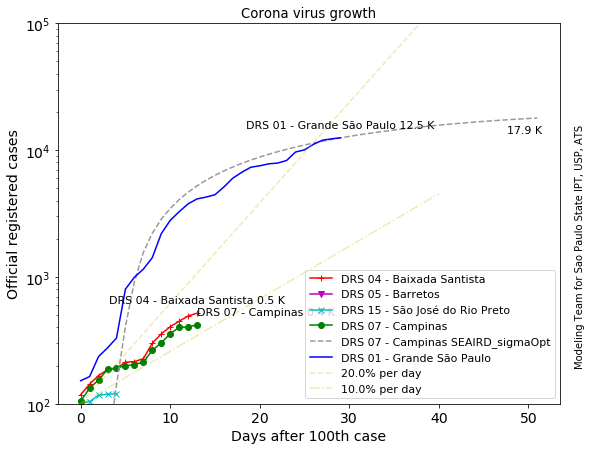

Infection speed= 6.083043397862167
Day with the maximum infections occurred= 20
Total number of recorded infected people at the infection’s end= 15183
Errors =  [0.4564542410217921, 1.0345562753760784]


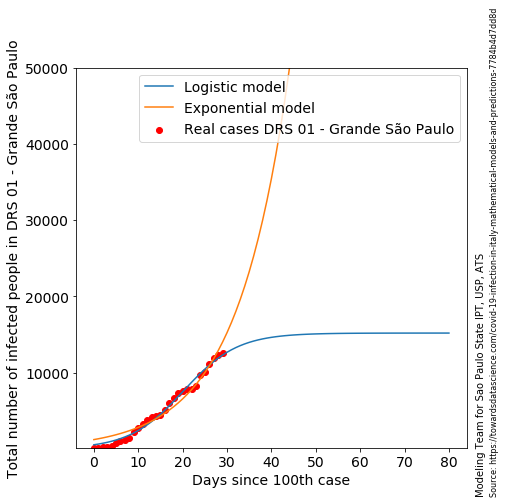

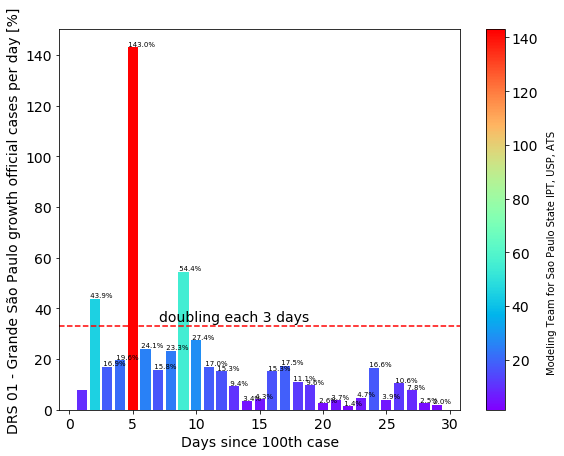

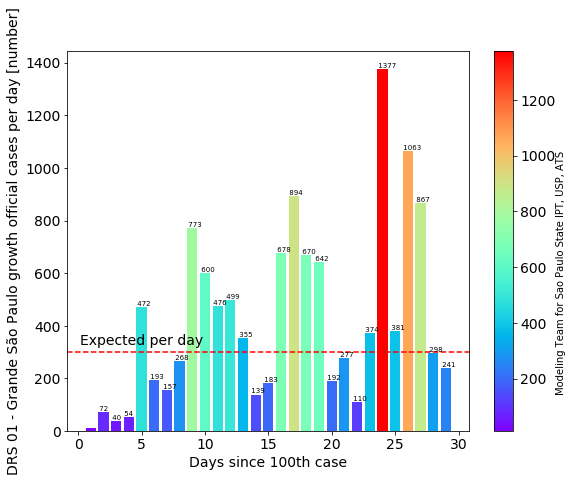

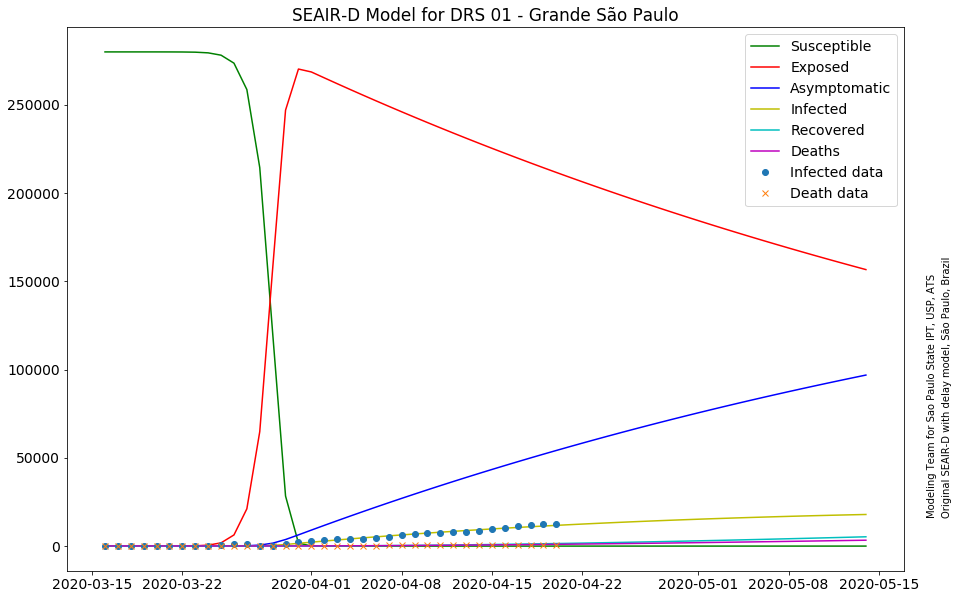

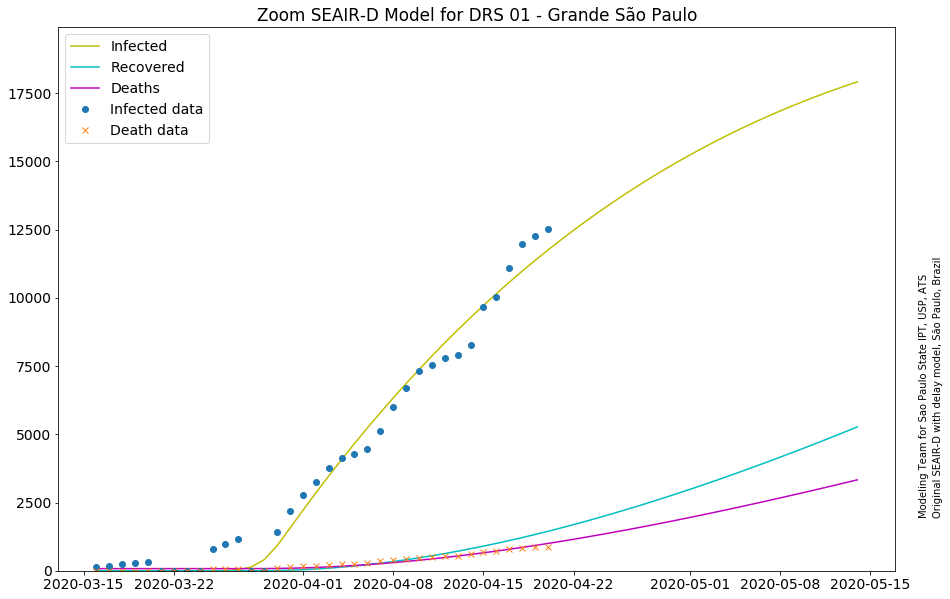

In [39]:
covid_plots.covid_plots(districtRegion, districts4Plot, startdate,predict_range, startCase, opt, version, show=True)